# Ensemble Clustering for Graphs (ECG) - Extra features

Beside providing a good, stable graph clustering method, ECG can be useful for a few other tasks:

### (1) refuse to cluster scores

We can define some **refuse to cluster scores** to rank the nodes in decreasing order, from ther most likely to be an outlier (i.e. not part of a community) to the least likely. This can be useful for tasks such as **outlier detection**, but also to improve the **robustness** of the clustering results by leaving out nodes that are not stongly memeber of any community. The current version of ECG has two such scores:

For each node $v$, let $N(v)$ be its set of neighbors, and $C(v)$ its community found with ECG.
For each edge $e=(u,v)$, let $0 \le s(e) \le 1$ be its ECG edge score.
We define two refusal to cluster scores for vertex $v$:

* 'overall' score: $1 - \sum_{u \in N(v)} s((u,v)) / |N(v)|$
* 'community'-based score: $\sum_{u \in N(v) ; C(u) \ne C(v)} s((u,v)) / \sum_{u \in N(v)} s((u,v))$

### (2) improving graph layouts

Another use for the derived ECG edge weights is to obtain better layouts for community graphs. We illustrate this using the popular **Fruchterman-Reingold** layout algorithm.

### (3) Community strength indidcator (CSI)

This measure was proposed in: https://link.springer.com/chapter/10.1007/978-3-030-05411-3_19.
In a nutshell, it measures how close ECG edge weights are to a bi-modal distributions with weights at values 0 and 1 using a **point-mass Wasserstein distance**. Values close to 1 are indicative of strong communities.

### Datasets

We illustrate the above for a few datasets:
* US college football graph, which has some known outlier nodes, and
* a few ABCD-o benchmark graphs (see https://github.com/bkamins/ABCDGraphGenerator.jl), also with some outlier nodes.


In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import partition_igraph
from sklearn.metrics import adjusted_rand_score as ARI
from collections import Counter

## the data directory
datadir = './Data/'


## US College Football Graph

This is a nice, small graph for illustrating anomaly detection methods.
The graph consists of 115 US college football teams (nodes) playing games (edges). Teams are part of 12 conferences (the 'communities'):
*   0 = Atlantic Coast
*   1 = Big East
*   2 = Big Ten
*   3 = Big Twelve
*   4 = Conference USA
*   5 = Independents
*   6 = Mid-American
*   7 = Mountain West
*   8 = Pacific Ten
*   9 = Southeastern
*  10 = Sun Belt
*  11 = Western Athletic

14 teams out of 115 appear as "anomalies" as can be seen in Figure 5 of [REF], namely:
- 5 teams in #5 conference (Independent) play teams in other conferences (green triangles in plot below)
- 7 teams in #10 conference (Sun Belt) are broken in 2 clumps (pink triangles in plot below) 
- 2 teams from #11 conference play mainly with #10 conference (red triangles below)

[Ref]: "Community structure in social and biological networks", M. Girvan and M. E. J. Newman
PNAS June 11, 2002 99 (12) 7821-7826; https://doi.org/10.1073/pnas.122653799



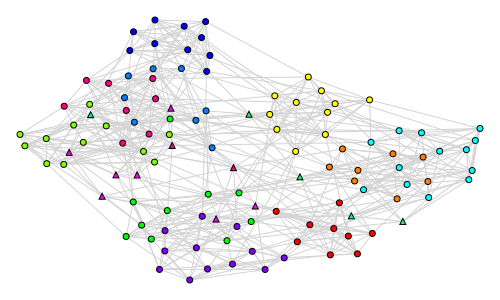

In [2]:
## read graph and communities
cfg = ig.Graph.Read_Ncol(datadir+'Football/football.edgelist',directed=False)
c = np.loadtxt(datadir+'Football/football.community',dtype='uint16',usecols=(0))
cfg.vs['community'] = [c[int(x['name'])] for x in cfg.vs]

## plot the College Football Graph
## show communities in dfferent colors
## show known anomalies as triangles
cfg.vs['shape'] = 'circle'
cfg.vs['anomaly'] = 0
pal = ig.RainbowPalette(n=max(cfg.vs['community'])+1) 
cfg.vs['color'] = [pal.get(int(i)) for i in cfg.vs['community']]
for v in cfg.vs:
    if v['community'] in [5,10] or v['name'] in ['28','58']:
        v['shape']='triangle'
        v['anomaly']=1
ly = cfg.layout_fruchterman_reingold()
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), vertex_size=6, edge_color='lightgray')


### experiment 1: refuse to cluster scores

Below, we rand the nodes in decreasing order of the chosen refusal score, and for each possible cutoff point (top-k), we compute the ARI (adjusted Rand index) and the number of true outliers found.

We see that we find the true outliers quickly, leading to improved clustering (better ARI) when we drop a few nodes.

In [3]:
## run ECG and return one of the two "refuse to cluster" scores
ecg = cfg.community_ecg(final='leiden', refuse_score=True)
cfg.vs['ecg'] = ecg.membership

## pick one of the two here:
#cfg.vs['refuse_score'] = ecg.refuse_overall
cfg.vs['refuse_score'] = ecg.refuse_community

In [4]:
L = []
n = cfg.vcount()
for i in range(n):
    srt = list(np.argsort(cfg.vs['refuse_score']))[:n-i]
    if i>0:
        L.append([i, ARI(cfg.vs[srt]['ecg'],cfg.vs[srt]['community']),
            sum([cfg.vs[i]['anomaly'] for i in list(np.argsort(cfg.vs['refuse_score']))[-i:]])])
    else:
        L.append([i, ARI(cfg.vs[srt]['ecg'],cfg.vs[srt]['community']),0])
df = pd.DataFrame(L, columns=['refusals','ARI','outliers found'])
df.head()

,refusals,ARI,outliers found
0,0,0.889343,0
1,1,0.904106,1
2,2,0.908456,2
3,3,0.919121,3
4,4,0.922843,4


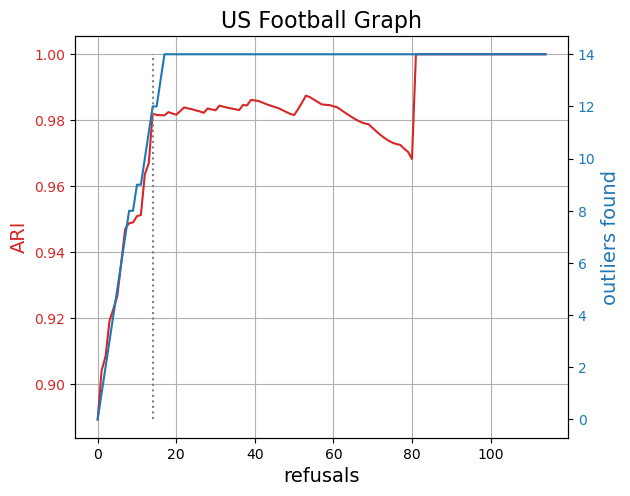

In [5]:
## plot the above values
## add vertical dashed line at 14, number of ground truth outliers

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('refusals', fontsize=14)
ax1.set_ylabel('ARI', color=color, fontsize=14)
ax1.plot(df['refusals'],df['ARI'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('outliers found', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(df['refusals'],df['outliers found'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('US Football Graph', fontsize=16)
plt.vlines(14,0,14,color='grey',linestyles='dotted')

plt.show()

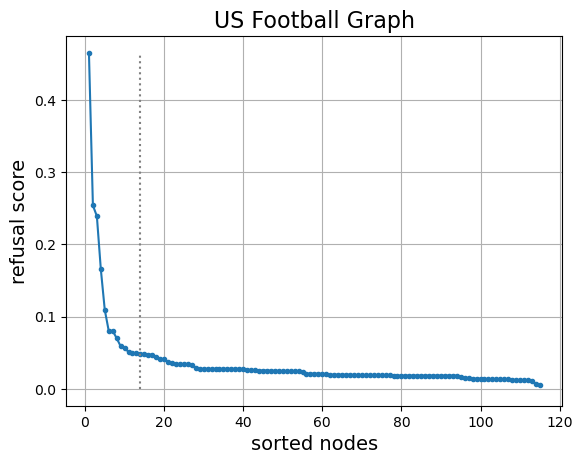

In [6]:
## plot the values of the refuse to cluster score in decreasing order
## add vertical dashed line at 14, number of ground truth outliers

srt = list(np.sort(cfg.vs['refuse_score']))
srt.reverse()
plt.plot(np.arange(1,n+1),srt,'.-')
plt.grid()
plt.vlines(14,0,srt[0],color='grey',linestyles='dotted')
plt.title('US Football Graph', fontsize=16)
plt.ylabel('refusal score', fontsize=14)
plt.xlabel('sorted nodes', fontsize=14);

### experiment 2: Fruchterman-Reingold layout

We alreasdy plotted the football graph above, before running ECG. Here we plot again, this time using ECG edge weights. We clearly see tighter communities, and the outlier nodes (triangles) are better separated.

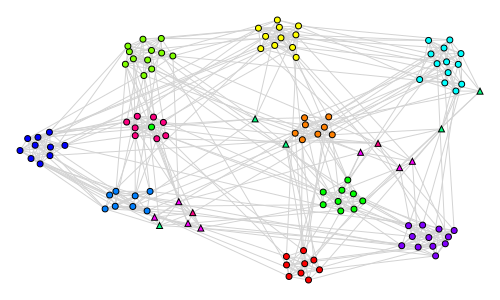

In [7]:
## use ECG weights to show the football graph
cfg.es['weight'] = ecg.W
cfg.vs['size'] = 6
ly = cfg.layout_fruchterman_reingold(weights='weight')
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), edge_color='lightgray')

### putting the two together

Below, we plot the ECG-weighted layout, but we also show nodes with size proportional to their respective "refuse to cluster" scores. 

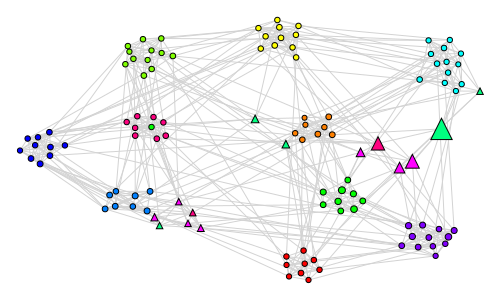

In [8]:
## re-size nodes w.r.t. score
m = np.min(cfg.vs['refuse_score'])
M = np.max(cfg.vs['refuse_score'])
cfg.vs['size'] = 5*(1+1.5*(cfg.vs['refuse_score'] - m)/(M-m)**2)
## plot
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), edge_color='lightgray')

## ABCD+o benchmark graphs

The ABCD model (Artificial Benchmark for Community Detection) provides a fast way to generate graphs with properties such as community structure, power law degree and community size distributiions and outlier (non-community) nodes. We consider a few such graphs with:
* 1000 nodes
* 950 nodes in communities, 50 "outlier" nodes (not strongly in a community)
* varying noise level (30%, 40% or 50%); this is the proportion of edges **between** communities

In the experiments below, when computing ARI, we group all outlier nodes are a single "community".


In [9]:
## read graph and communities (pick noise value below)
noise = 40 ## pick 30, 40 or 50

gfn = datadir+'ABCDo/Noise_'+str(noise)+'/edge.dat'
cfn = datadir+'ABCDo/Noise_'+str(30)+'/com.dat'
g = ig.Graph.Read_Ncol(gfn,directed=False)
c = np.loadtxt(cfn,dtype='uint16',usecols=(1))
g.vs['community'] = [c[int(x['name'])-1]-1 for x in g.vs]
g.vs['size'] = 5
g.es['color'] = 'grey'
cls = ['red','green','blue','gold','purple','black','brown','cyan','magenta']
g.vs['color'] = [cls[i] for i in g.vs['community']]


We plot the graph with Fruchterman-Reingold (FR) layout. Communities are shown in color and outliers as triangles.

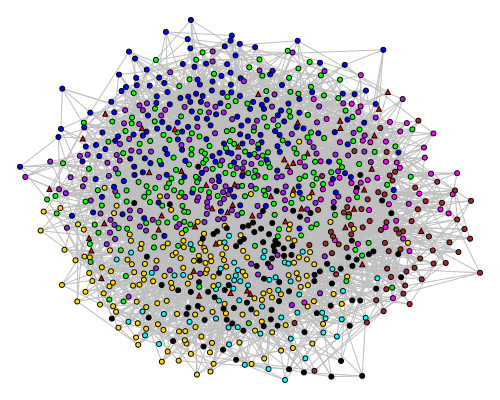

In [10]:
## FR layout plot
## we show communities with colors, outliers with triangles

ly = g.layout_fruchterman_reingold()
g.vs['shape'] = 'circle'
g.vs['anomaly'] = 0
for v in g.vs:
    if v['community']==0:
        v['shape'] = 'triangle'
        v['anomaly'] = 1
ig.plot(g, layout=ly, bbox=(0,0,500,400))

### experiment 1: refuse to cluster scores

Below, we rand the nodes in decreasing order of the chosen refusal score, and for each possible cutoff point (top-k), we compute the ARI (adjusted Rand index) and the number of true outliers found.

We see that we find several outliers quickly, leading to improved clustering (better ARI) when we drop a few nodes.

In [11]:
## run ECG
ecg = g.community_ecg(ens_size=32, final='leiden', resolution=1.0, refuse_score=True)
g.vs['ecg'] = ecg.membership

## pick one
#g.vs['refuse_score'] = ecg.refuse_overall
g.vs['refuse_score'] = ecg.refuse_community

In [12]:
n = g.vcount()
L = []
for i in range(n):
    srt = list(np.argsort(g.vs['refuse_score']))[:n-i]
    if i>0:
        L.append([i, ARI(g.vs[srt]['ecg'],g.vs[srt]['community']),
            sum([g.vs[i]['anomaly'] for i in list(np.argsort(g.vs['refuse_score']))[-i:]])])
    else:
        L.append([i, ARI(g.vs[srt]['ecg'],g.vs[srt]['community']),0])
df = pd.DataFrame(L, columns=['refusals','ARI','outliers found'])
df.head()

,refusals,ARI,outliers found
0,0,0.906633,0
1,1,0.907743,1
2,2,0.909349,2
3,3,0.909317,2
4,4,0.910027,3


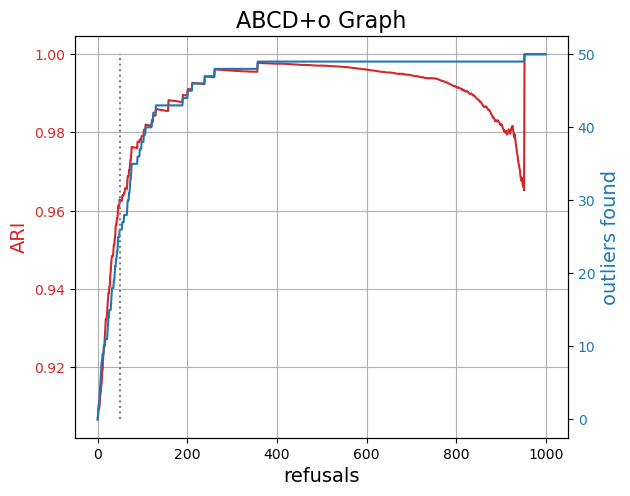

In [13]:
## plot the above values
## add vertical dashed line at 50, number of ground truth outliers

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('refusals', fontsize=14)
ax1.set_ylabel('ARI', color=color, fontsize=14)
ax1.plot(df['refusals'],df['ARI'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('outliers found', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(df['refusals'],df['outliers found'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('ABCD+o Graph', fontsize=16)
plt.vlines(50,0,50,color='grey',linestyles='dotted')
plt.show()

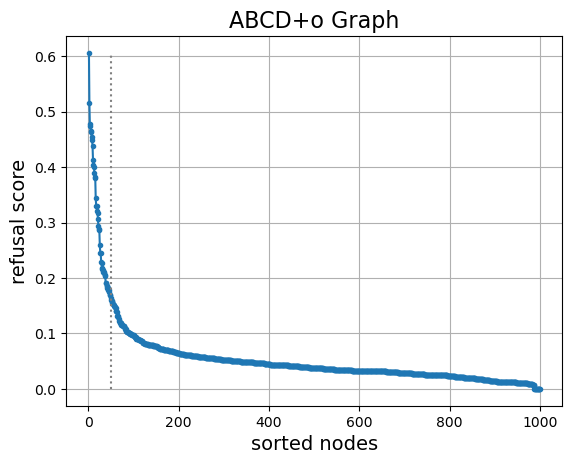

In [14]:
## plot the values of the refuse to cluster score in decreasing order
## add vertical dashed line at 50, number of ground truth outliers

srt = list(np.sort(g.vs['refuse_score']))
srt.reverse()
plt.plot(np.arange(1,n+1),srt,'.-')
plt.grid()
plt.vlines(50,0,srt[0],color='grey',linestyles='dotted')
plt.title('ABCD+o Graph', fontsize=16)
plt.ylabel('refusal score', fontsize=14)
plt.xlabel('sorted nodes', fontsize=14);

### experiment 2: Fruchterman-Reingold layout

We already plotted the ABCD-o graph above with FR layout, before running ECG. Here we plot again, this time using ECG edge weights. We clearly see tighter communities, and the outlier nodes (triangles) are better separated.

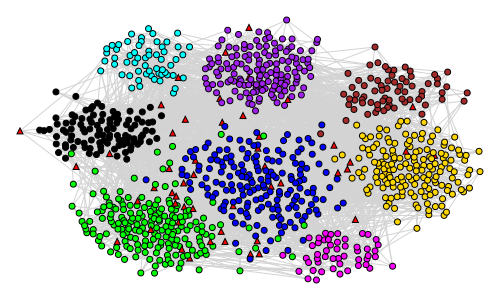

In [15]:
ecg = g.community_ecg(final='leiden', refuse_score=True)
g.es['weight'] = ecg.W
g.vs['size'] = 6
g.vs['ecg'] = ecg.membership
ly = g.layout_fruchterman_reingold(weights='weight')
ig.plot(g, layout=ly, bbox=(0,0,500,300), edge_color='lightgray')

### experiment 3 - Community Strength Index

It is not clear apriori how strong the communities are in a graph, as ground-truth communities are usually unknown. The CSI based on ECG edge weights can be use to quantify this, in particular to compare various graphs. Below we compute CSI for the three ABCD-o graphs with noise levels respectively 30%, 40% and 50%.

From this small sample, we see the expected decreasing values for the CSI index as we increase the noise, as the communities get harder to recover.


In [16]:
## read graph and communities (pick noise value below)
for noise in [30,40,50]:
    gfn = datadir+'ABCDo/Noise_'+str(noise)+'/edge.dat'
    cfn = datadir+'ABCDo/Noise_'+str(30)+'/com.dat'
    g = ig.Graph.Read_Ncol(gfn,directed=False)
    c = np.loadtxt(cfn,dtype='uint16',usecols=(1))
    g.vs['community'] = [c[int(x['name'])-1]-1 for x in g.vs]
    ecg = g.community_ecg(ens_size=32, final='leiden', resolution=1.0)
    print('percent noise:',noise,'CSI:',ecg.CSI)


percent noise: 30 CSI: 0.8886856045390641
percent noise: 40 CSI: 0.8417472132958426
percent noise: 50 CSI: 0.5808370154649529
